Tutorial 3: Non-linear Search
=============================

Its finally time to take our model and fit it to data, hurrah!

So, how do we infer the parameters for the 1D `Gaussian` that give a good fit to our data?  In the last tutorial, we
tried a very basic approach, randomly guessing models until we found one that gave a good fit and high log_likelihood.

We discussed that this wasn`t a viable strategy for more complex models. Surprisingly, this is the basis of how model
fitting actually works! Basically, our model-fitting algorithm guesses lots of models, tracking the log likelihood of
these models. As the algorithm progresses, it begins to guess more models using parameter combinations that gave higher
log_likelihood solutions previously. If a set of parameters provided a good fit to the data previously, a model with
similar values probably will too.

This is called a `NonLinearSearch` and its a fairly common tool used by scientists in a wide range of fields. We're
going to use a NonLinearSearch algorithm called `Emcee`, which for those familiar with statistic inference is a Markov
Chain Monte Carlo (MCMC) method. For now, lets not worry about the details of how Emcee actually works. Instead, just
picture that a `NonLinearSearch` in **PyAutoFit** operates as follows:

 1) Randomly guess a model and map the parameters via the priors to an instance of the model, in this case
 our `Gaussian`.

 2) Use this model instance to generate model data and compare this model data to the data to compute a log likelihood.

 3) Repeat this many times, choosing models whose parameter values are near those of models which have higher log
 likelihood values. If a new model's log likelihood is higher than previous models, new models will be chosen with
 parameters nearer this model.

The idea is that if we keep guessing models with higher log-likelihood values, we'll inevitably `climb` up the gradient
of the log likelihood in parameter space until we eventually hit the highest log likelihood models.

To be clear, this overly simplified description of an MCMC algorithm is not how the *NonLinearSearch* really works. We
are omitting crucial details on how our priors impact our inference as well as how the MCMC algorithm provides us with
reliable errors on our parameter estimates. The goal of this chapter to teach you how to use **PyAutoFit**, not how to
perform Bayesian inference. If you are interested in the details of how MCMC works, I recommend you checkout the
following web links:

https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autofit as af
from os import path
import matplotlib.pyplot as plt
import numpy as np

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


Load the dataset from the `autofit_workspace/dataset` folder.

In [2]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)

Lets remind ourselves what the data looks like, using the `plot_line` convenience method fom the previous tutorial.

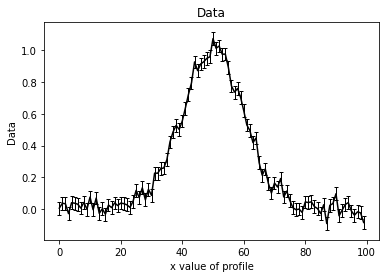

<Figure size 432x288 with 0 Axes>

In [3]:


def plot_line(xvalues, line, title=None, errors=None, ylabel=None):

    plt.errorbar(
        x=xvalues, y=line, yerr=errors, color="k", ecolor="k", elinewidth=1, capsize=2
    ),
    plt.title(title)
    plt.xlabel("x value of profile")
    plt.ylabel(ylabel)
    plt.show()
    plt.clf()


xvalues = np.arange(data.shape[0])

plot_line(xvalues=xvalues, line=data, errors=noise_map, title="Data", ylabel="Data")

Lets import the `Gaussian` class for this tutorial, which is the model we will fit using the `NonLinearSearch`.

In [4]:
import gaussian as g

The `NonLinearSearch` requires an `Analysis` class, which:

 - Receives the data to be fitted and prepares it so the model can fit it.
 
 - Defines the `log_likelihood_function` used to compute the `log_likelihood` from a model instance. 
 
 - Passes this `log_likelihood` to the `NonLinearSearch` so that it can determine parameter values for the the next 
 model that it samples.

For our 1D `Gaussian` model-fitting example, here is our `Analysis` class:

In [5]:


class Analysis(af.Analysis):
    def __init__(self, data, noise_map):

        super().__init__()

        self.data = data
        self.noise_map = noise_map

    def log_likelihood_function(self, instance):

        """
        The `instance` that comes into this method is an instance of the `Gaussian` class above, with the parameters
        set to values chosen by the `NonLinearSearch`. (These are commented out to prevent excessive print statements
        when we run the `NonLinearSearch`.

        This instance`s parameter values are chosen by the `NonLinearSearch` based on the previous model with the
        highest likelihood result.

            print("Gaussian Instance:")
            print("Centre = ", instance.centre)
            print("Intensity = ", instance.intensity)
            print("Sigma = ", instance.sigma)

        Below, we fit the data with the `Gaussian` instance, using its "profile_from_xvalues" function to create the
        model data.
        """
        xvalues = np.arange(self.data.shape[0])

        model_data = instance.profile_from_xvalues(xvalues=xvalues)
        residual_map = self.data - model_data
        chi_squared_map = (residual_map / self.noise_map) ** 2.0
        chi_squared = sum(chi_squared_map)
        noise_normalization = np.sum(np.log(2 * np.pi * noise_map ** 2.0))
        log_likelihood = -0.5 * (chi_squared + noise_normalization)

        return log_likelihood


To perform the `NonLinearSearch` using `Emcee`, we simply compose our model using a `PriorModel`, instantiate the 
`Analysis` class and pass them to an instance of the `Emcee` class. 

We also pass a `name` and `path_prefrix`, which specifies that when the results are output to the folder 
`autofit_workspace/output` they'll also be written to the folder `howtofit/chapter_1/tutorial_3`.

In [6]:
model = af.PriorModel(g.Gaussian)
model.centre = af.UniformPrior(lower_limit=0.0, upper_limit=100.0)
model.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=1e2)
model.sigma = af.UniformPrior(lower_limit=0.0, upper_limit=50.0)

analysis = Analysis(data=data, noise_map=noise_map)

emcee = af.Emcee(name="tutorial_3", path_prefix=path.join("howtofit", "chapter_1"))

We begin the `NonLinearSearch` by calling its `fit` method. This will take a minute or so to run (which is very fast 
for a model-fit). Whilst you're waiting, checkout the folder:

`autofit_workspace/output/howtofit/chapter_1`

Here, the results of the model-fit are output to your hard-disk (on-the-fly) and you can inspect them as the non-linear
search runs. In particular, you'll find:

 - `model.info`: A file listing every model component, parameter and prior in your model-fit.

 - `model.results`: A file giving the latest best-fit model, parameter estimates and errors of the fit.
 
 - `search`: A folder containing the `Emcee` output in hdf5 format.txt (you'll probably never need to look at these, 
   but its good to know what they are).
 
 - Other `metadata` which you can ignore for now.

In [7]:
result = emcee.fit(model=model, analysis=analysis)

print(
    "Emcee has begun running - checkout the autofit_workspace/output/howtofit/chapter_1/phase_t3"
    " folder for live output of the results."
    "This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!"
)

print("Emcee has finished run - you may now continue the notebook.")

INFO:root:tutorial_3 already completed, skipping non-linear search.


Emcee has begun running - checkout the autofit_workspace/output/howtofit/chapter_1/phase_t3 folder for live output of the results.This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!
Emcee has finished run - you may now continue the notebook.


Once completed, the `NonLinearSearch` returns a `Result` object, which contains lots of information about the 
NonLinearSearch.
 
A full description of the `Results` object will be given in tutorial 6 and can also be found at:
 
`autofit_workspace/overview/simple/results`
`autofit_workspace/overview/complex/results`.

In this tutorial, lets use the `result` it to inspect the maximum likelihood model instance.

In [8]:
print("Maximum Likelihood Model:\n")
max_log_likelihood_instance = result.samples.max_log_likelihood_instance
print("Centre = ", max_log_likelihood_instance.centre)
print("Intensity = ", max_log_likelihood_instance.intensity)
print("Sigma = ", max_log_likelihood_instance.sigma)

Maximum Likelihood Model:

Centre =  50.25825690111035
Intensity =  25.234981900212652
Sigma =  10.022826361644073


We can use this to plot the maximum log likelihood fit over the data:

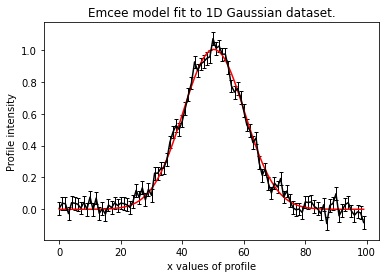

In [9]:
model_data = result.max_log_likelihood_instance.profile_from_xvalues(
    xvalues=np.arange(data.shape[0])
)
plt.errorbar(
    x=xvalues, y=data, yerr=noise_map, color="k", ecolor="k", elinewidth=1, capsize=2
)
plt.plot(xvalues, model_data, color="r")
plt.title("Emcee model fit to 1D Gaussian dataset.")
plt.xlabel("x values of profile")
plt.ylabel("Profile intensity")
plt.show()
plt.close()

Above, we used the `Result`'s `samples` property, which in this case is a `MCMCSamples` object:

In [10]:
print(result.samples)

This object acts as an interface between the `Emcee` output results on your hard-disk and this Python code. For
example, we can use it to get the parameters and log likelihood of an accepted emcee sample.

In [11]:
print(result.samples.parameters[10][:])
print(result.samples.log_likelihoods[10])

[50.65408732798956, 51.000189262339646, 24.928847317485115]
-2610.0758973675643


We can also use it to get a model instance of the `median_pdf` model, which is the model where each parameter is
the value estimated from the probability distribution of parameter space.

In [12]:
mp_instance = result.samples.median_pdf_instance
print()
print("Median PDF Model:\n")
print("Centre = ", mp_instance.centre)
print("Intensity = ", mp_instance.intensity)
print("Sigma = ", mp_instance.sigma)


Median PDF Model:

Centre =  50.25438954195039
Intensity =  25.236683259224893
Sigma =  10.022496511418097


we'll come back to the `Samples` objects in tutorial 6!